# <B> Anormaly Detection based on AutoEncoder </B>
* Container: codna_pytorch_p39

## AutoEncoder based anomaly detection

- **RaPP** - Novelty Detection with Reconstruction along Projection Pathway <br>
<p align="center">
    <img src="imgs/rapp-f1.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>
<p align="center">
    <img src="imgs/rapp-f2.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>

    * [Ppaer, ICLR 2020] https://openreview.net/attachment?id=HkgeGeBYDB&name=original_pdf
    * [Desc, KOREAN] [RaPP](https://makinarocks.github.io/rapp/)
    * [Supplement #1] [Autoencoder based Anomaly Detection](https://makinarocks.github.io/Autoencoder-based-anomaly-detection/)
    * [Supplement #2] [Reference code (github)](https://github.com/Aiden-Jeon/RaPP)
        

## AutoReload

In [1]:
%load_ext autoreload
%autoreload 2

## parameter store 설정

In [2]:
import boto3
from utils.ssm import parameter_store

In [3]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
strPrefix = pm.get_params(key="PREFIX")

## pramamters for tasks

In [4]:
strAccountId = pm.get_params(key="-".join([strPrefix, "ACCOUNT-ID"]))
strBucketName = pm.get_params(key="-".join([strPrefix, "BUCKET"]))
strExecutionRole = pm.get_params(key="-".join([strPrefix, "SAGEMAKER-ROLE-ARN"]))
strS3DataPath = pm.get_params(key="-".join([strPrefix, "S3-DATA-PATH"]))

In [5]:
print (f"prefix: {strPrefix}")
print (f"account_id: {strAccountId}")
print (f"defaulut_bucket: {strBucketName}")
print (f"sagemaker_role: {strExecutionRole}")
print (f"s3_data_path: {strS3DataPath}")

prefix: ad-ts
account_id: 419974056037
defaulut_bucket: sm-anomaly-detection-dongjin
sagemaker_role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
s3_data_path: s3://sm-anomaly-detection-dongjin/data


## 1. Data manipulation and visualization

In [6]:
import os
import pandas as pd
from utils.util import plot_click_w_fault_and_res, plot_click_w_fault_res_ad, plot_click_w_ad_exp

* load data and derive features

In [7]:
clicks_1T = pd.read_csv(os.path.join(strS3DataPath, "clicks_1T.csv"), parse_dates=["timestamp"]).set_index("timestamp")
clicks_1T["residual"] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T["fault"] = pd.read_csv(os.path.join(strS3DataPath, "fault_label_1T.csv"), header=None).values[0] ## label
clicks_1T["time"] = [int(str(time).split(" ")[1].split(":")[0]) for time in clicks_1T.index] ## time variable

In [8]:
print (f'data shape: {clicks_1T.shape}')
print (f'timestamp min: {clicks_1T.index.min()}, max: {clicks_1T.index.max()}')

data shape: (12960, 6)
timestamp min: 2020-07-07 00:00:00, max: 2020-07-15 23:59:00


* visualization

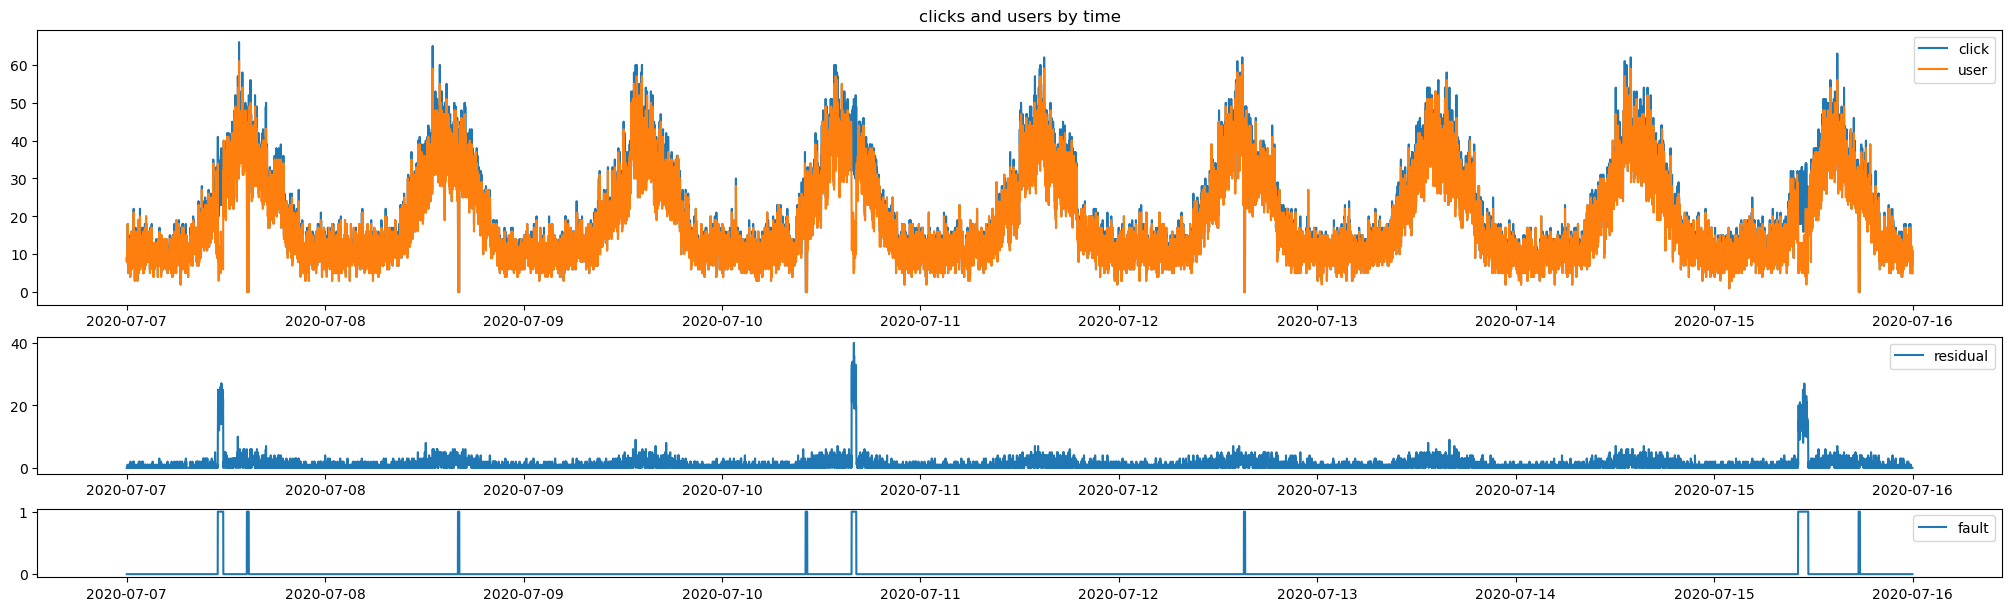

In [9]:
plot_click_w_fault_and_res(clicks_1T)

* upload data to s3 and local

In [10]:
strTrainDataName = "merged_clicks_1T.csv"
clicks_1T.to_csv(os.path.join(strS3DataPath, strTrainDataName), index=True) # to s3
clicks_1T.to_csv(os.path.join("./data", strTrainDataName), index=True) # to local

print (f'train_data_name: {strTrainDataName}')

train_data_name: merged_clicks_1T.csv


## 2. Processing-job for preprocessing

In [11]:
import os
import sagemaker
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


* params for processing job

In [12]:
local_mode = True

if local_mode: 
    strInstanceType = 'local_gpu'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    strDataPath = str(os.path.join("file://", os.getcwd(), "data"))
    
else:
    strInstanceType = "ml.m5.xlarge"
    sagemaker_session = sagemaker.Session()
    strDataPath = strS3DataPath
        
print (f"instance-type: {strInstanceType}")
print (f'role: {strExecutionRole}')
print (f"bucket: {strBucketName}")
print (f"dataset-path: {strDataPath}")
print (f"sagemaker_session: {sagemaker_session}")

instance-type: local_gpu
role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
bucket: sm-anomaly-detection-dongjin
dataset-path: /home/ec2-user/SageMaker/anomaly-detection-with-explanation/data
sagemaker_session: <sagemaker.local.local_session.LocalSession object at 0x7fab1959ac50>


* Define processing job

In [13]:
dataset_processor = FrameworkProcessor(
    estimator_cls=PyTorch,
    framework_version="2.0.0",
    py_version="py310",
    image_uri=None,
    instance_type=strInstanceType,
    instance_count=1,
    role=strExecutionRole,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "preprocessing",
    "output"
)

nShingleSize = 4

In [14]:
print (f'strOutputPath: {strOutputPath}')
print (f'nShingleSize: {nShingleSize}')

strOutputPath: s3://sm-anomaly-detection-dongjin/ad-ts/preprocessing/output
nShingleSize: 4


In [15]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src/preprocessing", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=strDataPath,
            destination=os.path.join(strProcPrefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(strProcPrefix, "output"),
            destination=strOutputPath
        ),
    ],
    arguments=[
        "--proc_prefix", strProcPrefix, \
        "--shingle_size", str(nShingleSize), \
        "--train_data_name", strTrainDataName
    ]
)

INFO:sagemaker:Creating processing-job with name preprocessing-2024-07-17-02-35-05-681
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.local.image:'Docker Compose' is not installed. Proceeding to check for 'docker-compose' CLI.
INFO:sagemaker.local.image:'Docker Compose' found using Docker Compose CLI.
INFO:sagemaker.local.local_session:Starting processing job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:

Login Succeeded


failed to register layer: Error processing tar file(exit status 1): write /opt/conda/nsight-compute/2022.3.0/target/linux-desktop-glibc_2_11_3-x64/ncu: no space left on device


CalledProcessError: Command '['docker', 'pull', '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:2.0.0-gpu-py310']' returned non-zero exit status 1.

* download preprocessed data to local

In [ ]:
!aws s3 sync $strOutputPath ./data/preprocessing --quiet

* save params

In [ ]:
pm.put_params(key="-".join([strPrefix, "PREP-DATA-PATH"]), value=strOutputPath, overwrite=True)
print (f'S3-PREP-DATA-PATH: {pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))}')

## 3. Training-job for anomaly detection

* check gpu

In [ ]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

In [ ]:
import os
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.inputs import TrainingInput

* **Set Up SageMaker Experiment**
    - Create or load [SageMaker Experiment](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) for the example training job. This will create an experiment trial object in SageMaker.
    - **pip instatll sagemaker-experiments**

In [ ]:
from time import strftime
from smexperiments.trial import Trial
from smexperi|ments.experiment import Experiment

In [ ]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)

In [ ]:
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name

* params for training job

In [ ]:
# Set to True to enable SageMaker to run locally
local_mode = True

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    strLocalDataDir = os.getcwd() + '/data/preprocessing'
    dicDataChannels = {
        "train": f"file://{strLocalDataDir}",
        "validation": f"file://{strLocalDataDir}"
    }
    
else:
    
    strInstanceType = "ml.g4dn.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    dicDataChannels = {
        "train": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))
    }

dicHyperParams = {
    "epochs":"150",
    "batch_size":"128", 
    "lr":"1e-2",
    "shingle_size":"4",
    "num_features":"4",
    "emb_size":"4",
    "workers":"2"
}

nInstanceCount = 1

bSpotTraining = False
if bSpotTraining:
    nMaxWait = 1*60*60
    nMaxRun = 1*60*60
    
else:
    nMaxWait = None
    nMaxRun = 1*60*60

bUseTrainWarmPool = False ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None
if bSpotTraining:
    bUseTrainWarmPool = False # warmpool은 spot instance 사용시 활용 할 수 없음
    nKeepAliveSeconds = None
    
    
strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output"
)

strCodeLocation = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "backup_codes"
)

strExperimentName = '-'.join([strPrefix, "experiments"])

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "Train loss", "Regex": f"loss={num_re}"},
    {"Name": "Train cos", "Regex": f"wer:{num_re}"},
    {"Name": "Val cos", "Regex": f"wer:{num_re}"}
]

kwargs = {}

In [ ]:
print (f'local_mode: {local_mode}')
print (f'sagemaker_session: {sagemaker_session}')
print (f'strInstanceType: {strInstanceType}')
print (f'dicDataChannels: {dicDataChannels}')
print (f'strOutputPath: {strOutputPath}')

* Define training job

In [ ]:
estimator = PyTorch(
    entry_point="main.py", # the script we want to run
    source_dir="./src/training", # where our conf/script is
    #git_config=git_config,
    role=strExecutionRole,
    instance_type=strInstanceType,
    instance_count=nInstanceCount,
    image_uri=None,
    framework_version="2.0.0",#"1.13.1", # version of PyTorch
    py_version="py310",#"py39",
    volume_size=256,
    code_location = strCodeLocation,
    output_path=strOutputPath,
    disable_profiler=True,
    debugger_hook_config=False,
    hyperparameters=dicHyperParams, #{'config-path': 'conf'},
    #distribution={"smdistributed":{"dataparallel":{"enabled":True, "fp16": True}}},
    sagemaker_session=sagemaker_session,
    metric_definitions=metric_definitions,
    max_run=nMaxRun,
    use_spot_instances=bSpotTraining,  # spot instance 활용
    max_wait=nMaxWait,
    keep_alive_period_in_seconds=nKeepAliveSeconds,
    enable_sagemaker_metrics=True,
    **kwargs
)

In [ ]:
if strInstanceType =='local_gpu': estimator.checkpoint_s3_uri = None

create_experiment(strExperimentName)
job_name = create_trial(strExperimentName)

estimator.fit(
    inputs=dicDataChannels, 
    job_name=job_name,
    experiment_config={
      'TrialName': job_name,
      'TrialComponentDisplayName': job_name,
    },
    wait=True,
)

In [ ]:
print (f'model data: {estimator.model_data}')

* save params

In [ ]:
pm.put_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]), value=estimator.model_data, overwrite=True)
print (f'S3-MODEL-ARTIFACT: {pm.get_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]))}')

## 4. Deploy

* params for deployment

In [ ]:
import time

In [ ]:
# Set to True to enable SageMaker to run locally
local_mode = False

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
else:
    strInstanceType = "ml.g4dn.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    sagemaker_session = sagemaker.Session()
    
strEndpointName = f"endpoint-{strPrefix}-{int(time.time())}"
    
print (f'instance_type: {strInstanceType}')
print (f'sagemaker_session: {sagemaker_session}')
print (f"Endpoint-name: {strEndpointName}")

* deploy

In [ ]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.serializers import CSVSerializer, NumpySerializer, JSONSerializer
from sagemaker.deserializers import JSONDeserializer, NumpyDeserializer

In [ ]:
pm.get_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]))

In [ ]:
esimator = PyTorchModel(
    source_dir="./src/deploy",
    entry_point="inference.py",
    model_data=pm.get_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"])),
    role=strExecutionRole,
    framework_version='2.0.0',
    py_version='py310',
    model_server_workers=1,
)

In [ ]:
predictor = esimator.deploy(
    endpoint_name=strEndpointName,
    instance_type=strInstanceType, 
    initial_instance_count=1,
    serializer=JSONSerializer('application/json'), ## 미적용 시 default: application/x-npy, boto3 기반 invocation시 무시
    deserializer=JSONDeserializer('application/json'), ## 미적용 시 default: application/x-npy, boto3 기반 invocation시 무시
    wait=False,  
    log=True,
)

In [ ]:
strEndpointName

* inference (invocation)

In [ ]:
import pickle

In [ ]:
def from_pickle(obj_path):
    with open(file=obj_path, mode="rb") as f:
        obj=pickle.load(f)
    return obj

In [ ]:
data_path = "./data/preprocessing/data_x_scaled_shingle.pkl"
data = from_pickle(data_path)
data = data[3, :]
dtype = data.dtype
shape = data.shape

In [ ]:
print (f'data: {data}')
print (f'dtype: {dtype}')
print (f'shape: {shape}')

* inference - using sagemaker SDK

In [ ]:
payload={"INPUT": data.tolist(), "SHAPE":shape, "DTYPE": str(dtype)}
#payload = json.dumps(payload)

In [ ]:
pred_results = predictor.predict(payload)
pred_results

* inference - using boto3 SDK

In [ ]:
import json
import boto3

### boto3 기반 invocation시 runtime_client가 필요함
* 이때 엔드포인트의 위치 (local/cloud)를 반드시 구분해 줘야함

In [ ]:
if strInstanceType == 'local_gpu': runtime_client = sagemaker.local.LocalSagemakerRuntimeClient()    
else: runtime_client = boto3.Session().client('sagemaker-runtime')
runtime_client

In [ ]:
endpoint_name = "endpoint--DJ-SM-PIPELINE-MODEL-1-1721175245"

In [ ]:
def invoke_endpoint(runtime_client, endpoint_name, payload, content_type):
    response = runtime_client.invoke_endpoint(
        EndpointName=endpoint_name, 
        ContentType=content_type, 
        Body=payload,
    )

    result = response['Body'].read().decode().splitlines()    
    
    return result

### [중요] boto3로 inference 할 때는 payload를 반드시 serialization 해서 넣어줘야 함
* sagemaker SDK는 deploy시 셋팅한 방식대로 serialization을 자동으로 해 준다
* boto3는 사용자가 직접 serialization을 한 후 inference 한다. (대신 serialization 자유도가 있다)

In [ ]:
payload = json.dumps(payload)

In [ ]:
start_time = time.time()
result = invoke_endpoint(
    runtime_client=runtime_client,
    endpoint_name=strEndpointName, 
    payload=payload,
    content_type='application/json'
)

print("--- %s seconds ---" % (time.time() - start_time))
print('result: ',  eval(result[0]))

* get anomaly scores

In [ ]:
data_path = "./data/preprocessing/data_x_scaled_shingle.pkl"
data = from_pickle(data_path)

In [ ]:
%%time
pred_results = []
for idx, record in enumerate(data):
    payload={"INPUT": record.tolist(), "SHAPE":shape, "DTYPE": str(dtype)}
    pred = predictor.predict(payload)
    pred_results.append(pred['pred'][0])
    if idx % 1000 == 0: print (f'{idx}/{data.shape[0]}')

In [ ]:
pdScores = pd.DataFrame(pred_results)

In [ ]:
pdScores

In [ ]:
strDataPath = "./data/preprocessing/data_y_shingle.pkl"
npTrainShingle_y = from_pickle(strDataPath)

#train_data_ratio = 0.99
#nShingleSize = 4
pdTrain_raw = clicks_1T[["page", "user", "click", "residual", "fault"]].iloc[nShingleSize-1:, :]
pdTrain_raw = pdTrain_raw.rename(columns={"page": "url"})
print (f"train_y_shingle: {npTrainShingle_y.shape}")

In [ ]:
pdScores.index = pdTrain_raw.index

In [ ]:
pdScores = pd.concat([pdTrain_raw, pdScores], axis=1)

In [ ]:
pdScores

## 4. Plotting the Prediction

Plot the anomalous points detected by AE.

###  - For Reconstruction Error

* Check the distribution of our anomaly score.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
threshold_re = pdScores['ANOMALY_SCORE'].mean() + 2.5*pdScores['ANOMALY_SCORE'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE'])
pdPlot.hist(bins=50)
plt.axvline(x=threshold_re, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_re,2)), xy=(threshold_re,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_re))

In [ ]:
anomalous = pdScores.query("ANOMALY_SCORE > @threshold_re")
stime = "2020-07-15 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-15 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

In [ ]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_re, start_dt=stime, end_dt=etime)

In [ ]:
pdAnomal = pdScores.query("ANOMALY_SCORE > @threshold_re")[["ANOMALY_SCORE", "URLS_ATTRIBUTION_SCORE", "USERS_ATTRIBUTION_SCORE", \
                                                         "CLICKS_ATTRIBUTION_SCORE", "RESIDUALS_ATTRIBUTION_SCORE", "ANOMALY_SCORE_SAP"]] 

In [ ]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label,
        bins=200
    )
plt.legend(prop={"size":16}, title = "label")

* performance metric

In [ ]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("ANOMALY_SCORE > @threshold_re").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE > @threshold_re").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [ ]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

###  - For SAP Score

In [ ]:
threshold_sap = pdScores['ANOMALY_SCORE_SAP'].mean() + 2.5*pdScores['ANOMALY_SCORE_SAP'].std()

pdPlot = pd.DataFrame(pdScores['ANOMALY_SCORE_SAP'])
pdPlot.hist(bins=50)
plt.axvline(x=threshold_sap, linestyle=':', c='r')
plt.annotate('threshold={}'.format(round(threshold_sap,2)), xy=(threshold_sap,6000), color='r')
plt.show()

print('3 sigma threshoud = {}'.format(threshold_sap))

In [ ]:
anomalous = pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap")
stime = "2020-07-15 09:00:00" # "2012-03-13 08:00:00"
etime = "2020-07-15 20:00:00" # "2012-03-13 20:00:00"
plot_click_w_fault_res_ad(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime)

In [ ]:
plot_click_w_ad_exp(pdScores, anomalous, threshold_sap, start_dt=stime, end_dt=etime, score="ANOMALY_SCORE_SAP")

In [ ]:
plt.figure(figsize = (18,5))
fault_types = [0, 1]
for fault_type in fault_types:
    
    if fault_type == 0: label = "Normal"
    else: label = "Fault"
    sns.distplot(
        pdScores[pdScores.fault==fault_type]["ANOMALY_SCORE_SAP"],
        hist=True,
        kde=True,
        kde_kws={"shade":True, "linewidth":3},
        label=label,
        bins=200
    )
plt.legend(prop={"size":16}, title = "label")

In [ ]:
precision = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("ANOMALY_SCORE_SAP > @threshold_sap").shape[0]
recall = pdScores.query("fault == 1 and ANOMALY_SCORE_SAP > @threshold_sap").shape[0] / pdScores.query("fault == 1").shape[0]
f1_score = 2*(precision*recall)/(precision+recall)

In [ ]:
print (f'Precision: {precision}')
print (f'Recall: {recall}')
print (f'f1_score: {f1_score}')

## Clean up

* delete endpoint

In [ ]:
class clean_up():
    
    def __init__(self, ):    
        pass
    
    def delete_endpoint(self, client, endpoint_name ,is_del_model=True):
        
        response = client.describe_endpoint(EndpointName=endpoint_name)
        EndpointConfigName = response['EndpointConfigName']

        response = client.describe_endpoint_config(EndpointConfigName=EndpointConfigName)
        model_name = response['ProductionVariants'][0]['ModelName']    

        if is_del_model: # 모델도 삭제 여부 임.
            client.delete_model(ModelName=model_name)    

        client.delete_endpoint(EndpointName=endpoint_name)
        client.delete_endpoint_config(EndpointConfigName=EndpointConfigName)    

        print(f'--- Deleted model: {model_name}')
        print(f'--- Deleted endpoint: {endpoint_name}')
        print(f'--- Deleted endpoint_config: {EndpointConfigName}')  


In [ ]:
clean = clean_up()
sm_client = boto3.client('sagemaker')
clean.delete_endpoint(sm_client, strEndpointName ,is_del_model=True)

In [ ]:
if "local" in instance_type:
    predictor.delete_endpoint(strEndpointName)